<a href="https://colab.research.google.com/github/shubhi-D/JS_learning/blob/main/DepressionDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import emoji
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
import torch


In [ ]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [ ]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [ ]:
# Read and Extract relevant dataset

# Read the dataset
dataset = pd.read_csv('Mental-Health-Twitter.csv')

# Extract relevant columns (tweets and labels)
tweets = dataset["post_text"]
labels = dataset["label"]

# Enhanced Text Preprocessing

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

In [ ]:
def preprocess_text(text):
    text = emoji.demojize(text)  # Convert emojis to text
    word_tokens = word_tokenize(str(text))  # Convert to string to handle potential NaN values
    filtered_text = [lemmatizer.lemmatize(word.lower()) for word in word_tokens if word.lower() not in stop_words and word.isalpha()]
    return " ".join(filtered_text)


In [ ]:
# Apply preprocessing to tweets

tweets = tweets.apply(preprocess_text)

# Convert text data into numerical features using TF-IDF

tfidf_vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1, 3))
X = tfidf_vectorizer.fit_transform(tweets)

# Split dataset into train and test sets

X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size=0.3, random_state=42)


In [ ]:
# Balancing the Dataset

smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)


In [ ]:
# Train Naive Bayes classifier
nb_classifier = MultinomialNB()
nb_classifier.fit(X_train_resampled, y_train_resampled)

MultinomialNB()

In [ ]:
# Hyperparameter tuning for Random Forest classifier
rf_classifier = RandomForestClassifier(random_state=42)
parameters = {'n_estimators': [100, 200], 'max_depth': [None, 10, 20]}
grid_search = GridSearchCV(rf_classifier, parameters, cv=5, scoring='f1')
grid_search.fit(X_train_resampled, y_train_resampled)
best_rf_classifier = grid_search.best_estimator_

In [ ]:
# Ensemble method: Voting Classifier
voting_classifier = VotingClassifier(estimators=[
    ('nb', nb_classifier), ('rf', best_rf_classifier)],
    voting='soft')
voting_classifier.fit(X_train_resampled, y_train_resampled)

VotingClassifier(estimators=[('nb', MultinomialNB()),
                             ('rf',
                              RandomForestClassifier(n_estimators=200,
                                                     random_state=42))],
                 voting='soft')

In [ ]:
# Evaluate models

def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    return accuracy, precision, recall, f1, y_pred

In [ ]:
nb_accuracy, nb_precision, nb_recall, nb_f1, nb_y_pred = evaluate_model(nb_classifier, X_test, y_test)
rf_accuracy, rf_precision, rf_recall, rf_f1, rf_y_pred = evaluate_model(best_rf_classifier, X_test, y_test)
voting_accuracy, voting_precision, voting_recall, voting_f1, voting_y_pred = evaluate_model(voting_classifier, X_test, y_test)



In [ ]:
print("Naive Bayes:")
print("Accuracy:", nb_accuracy)
print("Precision:", nb_precision)
print("Recall:", nb_recall)
print("F1 Score:", nb_f1)


Naive Bayes:
Accuracy: 0.8176666666666667
Precision: 0.8049476688867745
Recall: 0.8412330129267485
F1 Score: 0.8226904376012966


In [ ]:
print("\nRandom Forest:")
print("Accuracy:", rf_accuracy)
print("Precision:", rf_precision)
print("Recall:", rf_recall)
print("F1 Score:", rf_f1)


Random Forest:
Accuracy: 0.7928333333333333
Precision: 0.7581490104772992
Recall: 0.8634405038117335
F1 Score: 0.8073764140709747


In [ ]:
print("\nVoting Classifier:")
print("Accuracy:", voting_accuracy)
print("Precision:", voting_precision)
print("Recall:", voting_recall)
print("F1 Score:", voting_f1)


Voting Classifier:
Accuracy: 0.8136666666666666
Precision: 0.7833482542524619
Recall: 0.8700696055684455
F1 Score: 0.8244346733668341


In [ ]:
# Data Visualization

# Bar Graph for Performance Metrics
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
nb_scores = [nb_accuracy, nb_precision, nb_recall, nb_f1]
rf_scores = [rf_accuracy, rf_precision, rf_recall, rf_f1]
voting_scores = [voting_accuracy, voting_precision, voting_recall, voting_f1]


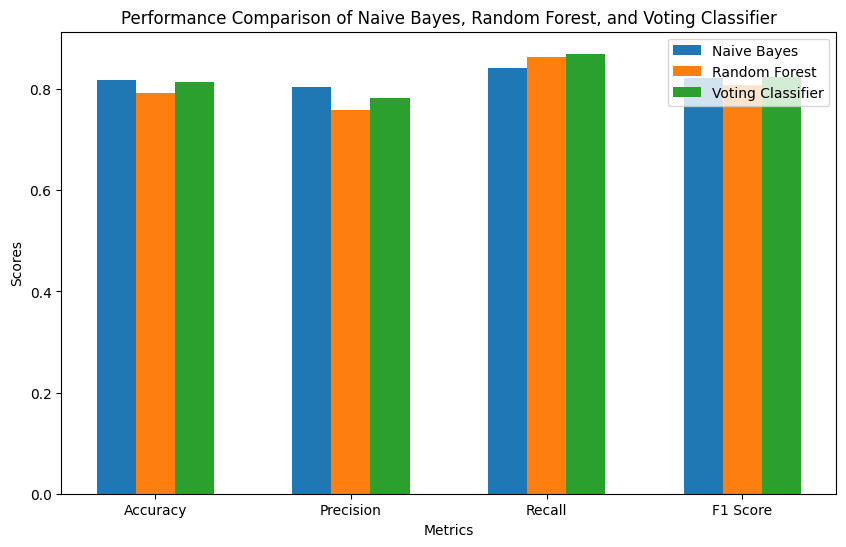

In [ ]:
x = range(len(metrics))

plt.figure(figsize=(10, 6))
plt.bar(x, nb_scores, width=0.2, label='Naive Bayes', align='center')
plt.bar([p + 0.2 for p in x], rf_scores, width=0.2, label='Random Forest', align='center')
plt.bar([p + 0.4 for p in x], voting_scores, width=0.2, label='Voting Classifier', align='center')
plt.xlabel('Metrics')
plt.ylabel('Scores')
plt.title('Performance Comparison of Naive Bayes, Random Forest, and Voting Classifier')
plt.xticks([p + 0.2 for p in x], metrics)
plt.legend()

plt.show()

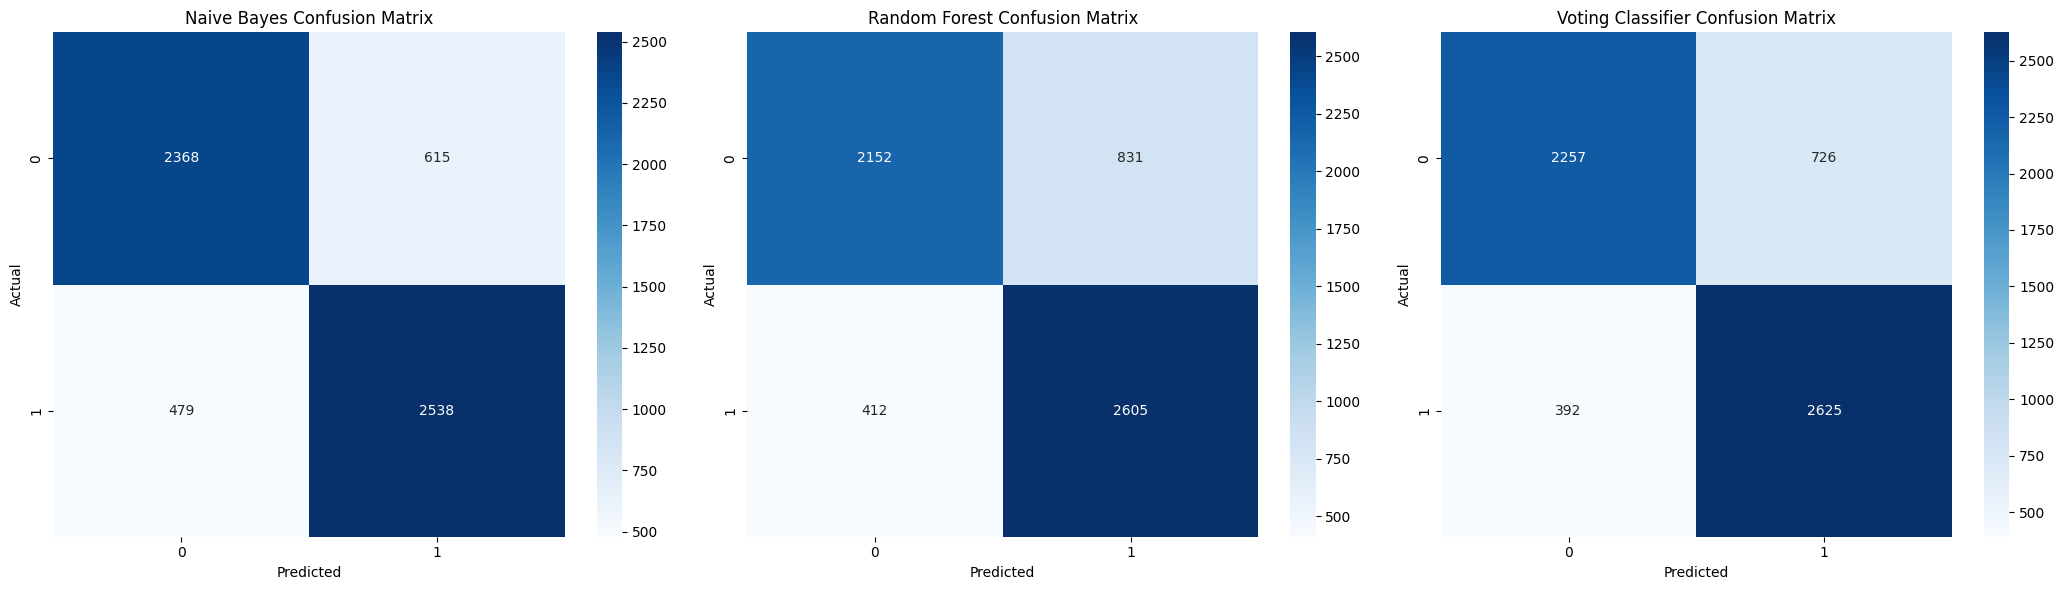

In [ ]:
# Confusion Matrix
nb_cm = confusion_matrix(y_test, nb_y_pred)
rf_cm = confusion_matrix(y_test, rf_y_pred)
voting_cm = confusion_matrix(y_test, voting_y_pred)

plt.figure(figsize=(21, 6))

plt.subplot(1, 3, 1)
sns.heatmap(nb_cm, annot=True, fmt='d', cmap='Blues')
plt.title('Naive Bayes Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.subplot(1, 3, 2)
sns.heatmap(rf_cm, annot=True, fmt='d', cmap='Blues')
plt.title('Random Forest Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.subplot(1, 3, 3)
sns.heatmap(voting_cm, annot=True, fmt='d', cmap='Blues')
plt.title('Voting Classifier Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.tight_layout()
plt.show()

In [ ]:
# Function for Predicting Depression using ensemble model

def predict_depression(sentence):
    # Preprocess input sentence
    processed_sentence = preprocess_text(sentence)
    # Convert to TF-IDF vector
    sentence_vector = tfidf_vectorizer.transform([processed_sentence])
    # Predict using the voting classifier
    voting_prediction = voting_classifier.predict(sentence_vector)[0]
    return voting_prediction

In [ ]:
# Test

input_sentence = "Even now the smallest thing still makes my heart break. I doesn't feel like that ever goes away."
voting_pred = predict_depression(input_sentence)
print("Voting Classifier prediction:", voting_pred)

input_sentence = "OUR new President can't write with either hand!!! https://t.co/5hk4rmNipJ"
voting_pred = predict_depression(input_sentence)
print("Voting Classifier prediction:", voting_pred)

Voting Classifier prediction: 1
Voting Classifier prediction: 0


In [ ]:
# Test

input_sentence = " I doesn't feel like that ever goes away."
voting_pred = predict_depression(input_sentence)
print("Voting Classifier prediction:", voting_pred)

input_sentence = "OUR new President can't write with either hand!!! "
voting_pred = predict_depression(input_sentence)
print("Voting Classifier prediction:", voting_pred)

Voting Classifier prediction: 1
Voting Classifier prediction: 0
